In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dados_f1 = 'https://raw.githubusercontent.com/alura-cursos/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F1.csv'
dados_f2 = 'https://raw.githubusercontent.com/alura-cursos/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F2.csv'
dados_f3 = 'https://raw.githubusercontent.com/alura-cursos/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F3.csv'

df_f1 = pd.read_csv(dados_f1)

df_f1.columns = [col.lower() for col in df_f1.columns]
df_f1["data"] = pd.to_datetime(df_f1["data"])
df_f1.set_index(["data"], inplace=True, drop=True)
df_f1

,temp
data,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


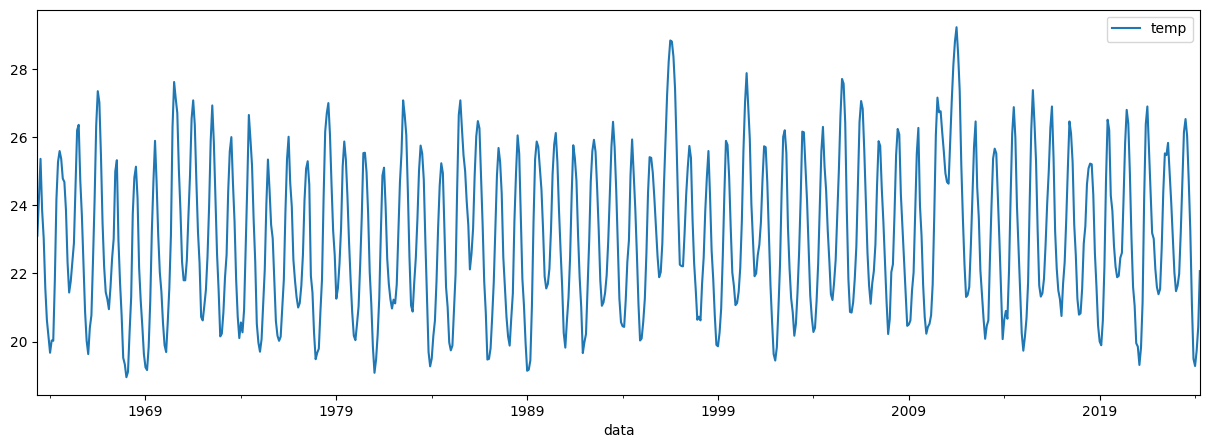

In [2]:
df_f1.plot(figsize=(15, 5))
plt.show()

# Stationarity Tests

In [35]:
from statsmodels.tsa.stattools import adfuller, kpss

def estac(df):
    adf = adfuller(df)
    kpss_saida = kpss(df)

    models = [adf, kpss_saida]
    names = ["ADF", "KPSS"]

    for model, name in zip(models, names):
        print(f"{name} p-value: {model[1]:.4f}", )
        if name == "ADF":
            if model[1] > 0.05:
                print("Não rejeitar a hipótese nula: A série não é estacionária\n")
            else:
                print("Rejeitar a hipótese nula: A série é estacionária\n")
        else:
            if model[1] < 0.05:
                print("Não rejeitar a hipótese nula: A série não é estacionária\n")
            else:
                print("Rejeitar a hipótese nula: A série é estacionária\n")
    

In [36]:
estac(df_f1)

ADF p-value: 0.0000
Rejeitar a hipótese nula: A série é estacionária

KPSS p-value: 0.0798
Rejeitar a hipótese nula: A série é estacionária



In [5]:
divisao = int(len(df_f1)*0.70)

train = df_f1.iloc[:divisao].asfreq("MS")
test = df_f1.iloc[divisao:].asfreq("MS")

# Analysing Correlation

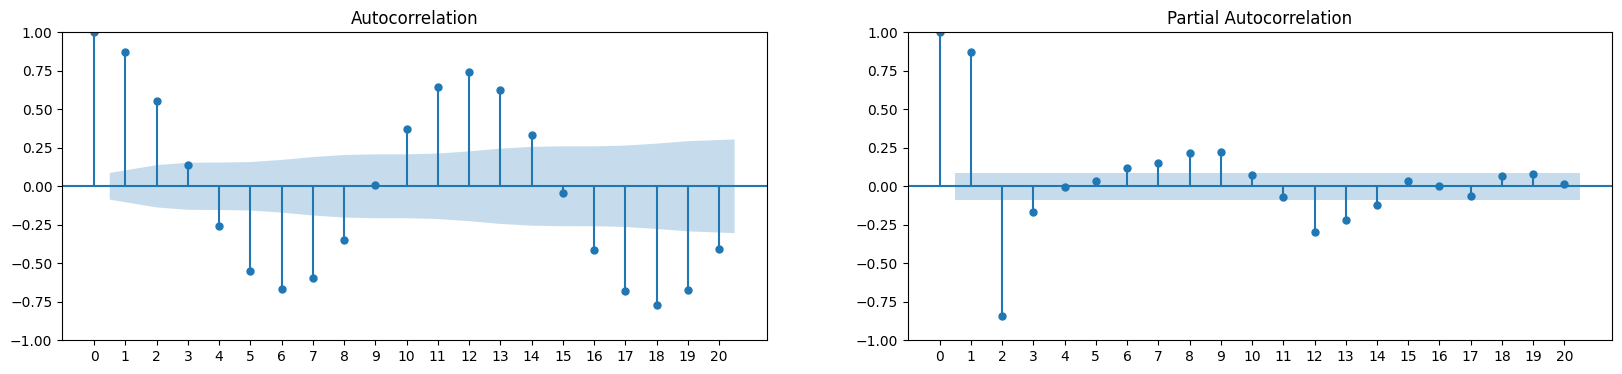

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(1, 2, figsize=(20, 4))

plot_acf(train, lags=20, ax=axs[0])
plot_pacf(train, lags=20, ax=axs[1])
axs[0].set_xticks(range(0, 21))
axs[1].set_xticks(range(0, 21))
plt.show()

# AR Model

In [7]:
from statsmodels.tsa.ar_model import AutoReg

ar_mod = AutoReg(train, 14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Thu, 29 Aug 2024   AIC                            666.981
Time:                        14:53:02   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
temp.L1        1.1971      0.044     27.078      0.000       1.110       1.284
temp.L2       -0.3092      0.069     -4.470      0.0

d:\Documents\Coding\Repositorios\MyRepositories\Alura\TimeSeries\.venv\Lib\site-packages\statsmodels\tsa\ar_model.py:1138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_params[lag] = -params[i]


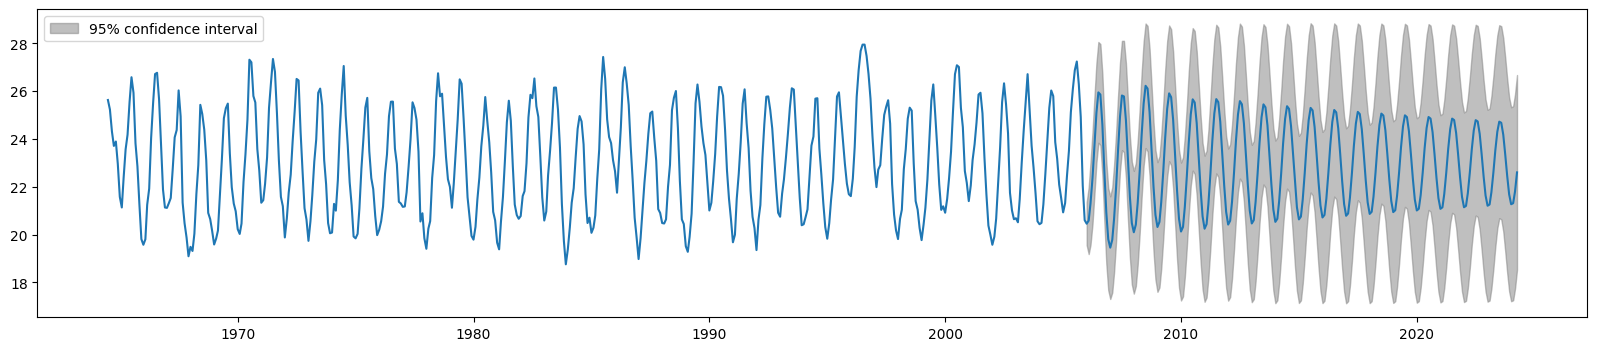

In [8]:
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict("1964", len(train) + len(test)-1, figsize=(20, 4))

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod=""):
    previsoes = mod.predict(len(treino), len(treino) + len(teste) - 1, dynamic=False)

    plt.figure(figsize=(16, 5))

    plt.plot(teste.index, teste, label="Esperado")
    plt.plot(previsoes.index, previsoes, label="Previsto", color='red')

    plt.title(f"Previsão modelo {nome_mod}")
    plt.ylabel("Temperatura")
    plt.legend()
    plt.show()

    print("Métricas:")
    mae = mean_absolute_error(teste, previsoes)
    print("MAE:", mae)
    mse = mean_squared_error(teste, previsoes)
    print("MSE", mse)

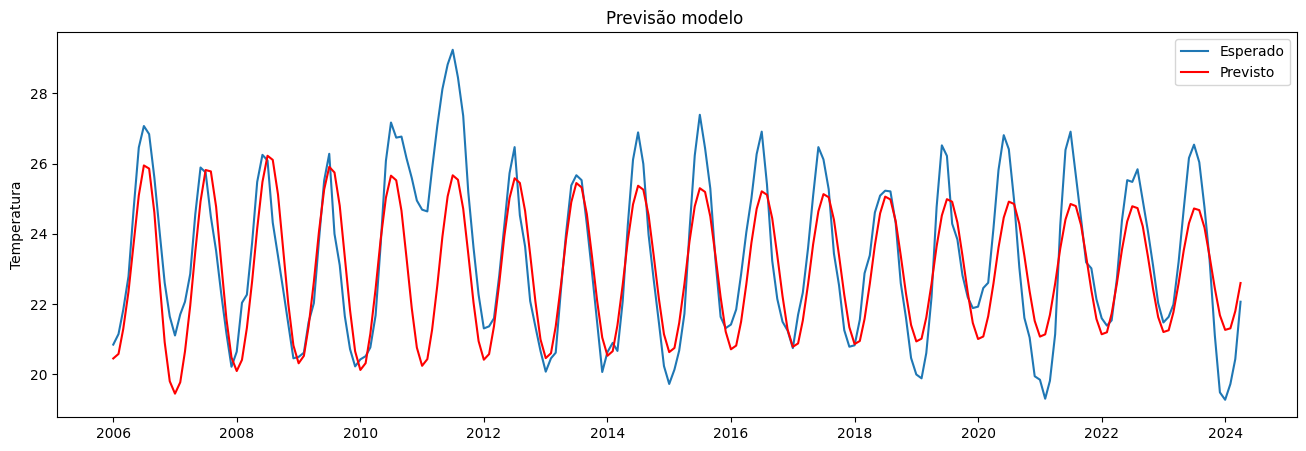

Métricas:
MAE: 1.0427063983973868
MSE 1.8489038142171543


In [10]:
plot_prev(train, test, ar_res, "")

# Selecting AR Order

In [11]:
from statsmodels.tsa.ar_model import ar_select_order

ar_selecao = ar_select_order(train, 35, old_names=False, ic="aic")
print(ar_selecao.ar_lags)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [12]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Thu, 29 Aug 2024   AIC                            603.684
Time:                        14:53:03   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
temp.L1        1.1355      0.045     25.067      0.000       1.047       1.224
temp.L2       -0.2017      0.068     -2.958      0.0

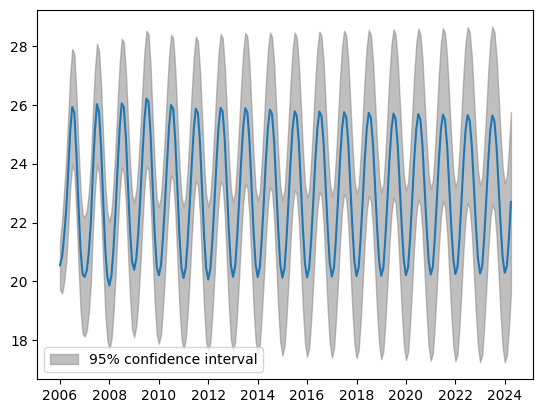

In [13]:
fig = ar_sel_res.plot_predict(len(train), len(train)+len(test)-1)

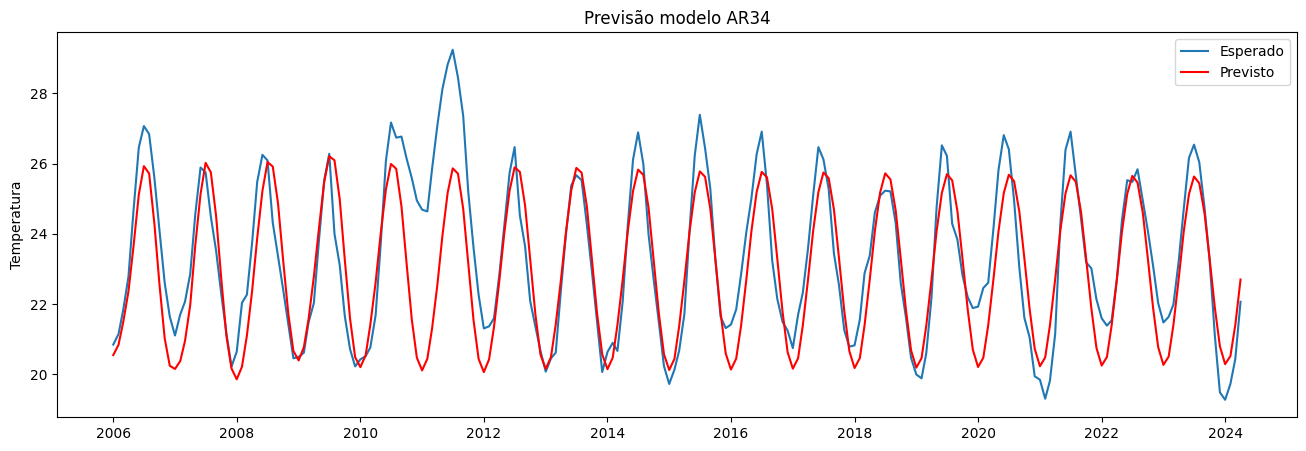

Métricas:
MAE: 0.9474776896250366
MSE 1.6610673113369703


In [14]:
plot_prev(train, test, ar_sel_res, "AR34")

# Second DataSet

In [15]:
df_f2 = pd.read_csv(dados_f2)
df_f2

df_f2.columns = [col.lower() for col in df_f2.columns]
df_f2["data"] = pd.to_datetime(df_f2["data"])
df_f2.set_index(["data"], inplace=True, drop=True)

<Axes: xlabel='data'>

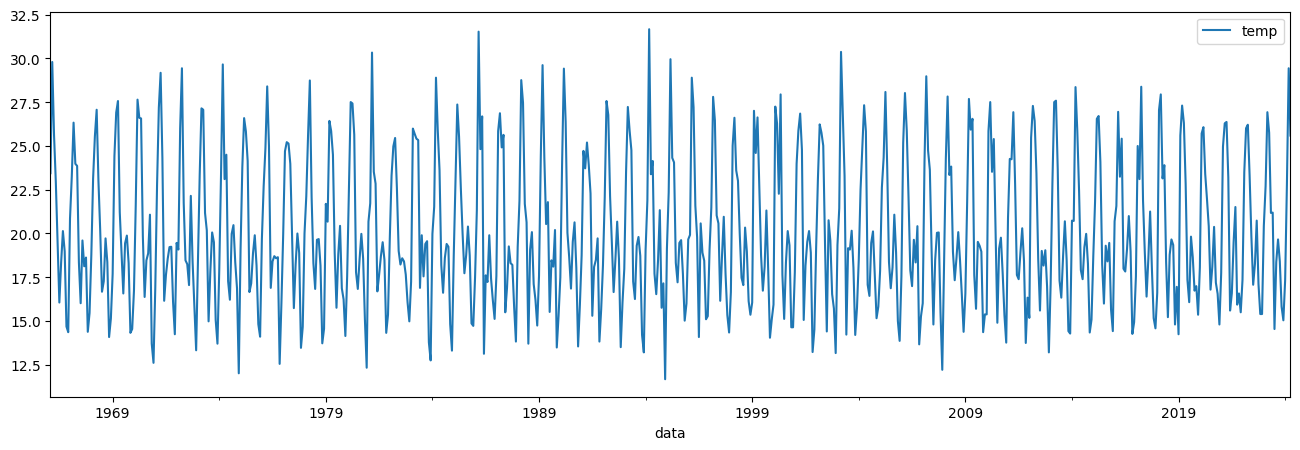

In [16]:
df_f2.plot(figsize=(16, 5))

In [17]:
estac(df_f2)

ADF p-value: 0.0000
Rejeitar a hipótese nula: A série é estacionária

KPSS p-value: 0.1000
Não rejeitar a hipótese nula: A série não é estacionária



C:\Users\lreis\AppData\Local\Temp\ipykernel_5596\517867373.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_saida = kpss(df)


In [18]:
divisao = int(len(df_f2)*0.8)

treino = df_f2.iloc[:divisao].asfreq("MS")
teste = df_f2.iloc[divisao:].asfreq("MS")

## Autocorrelation Analysis

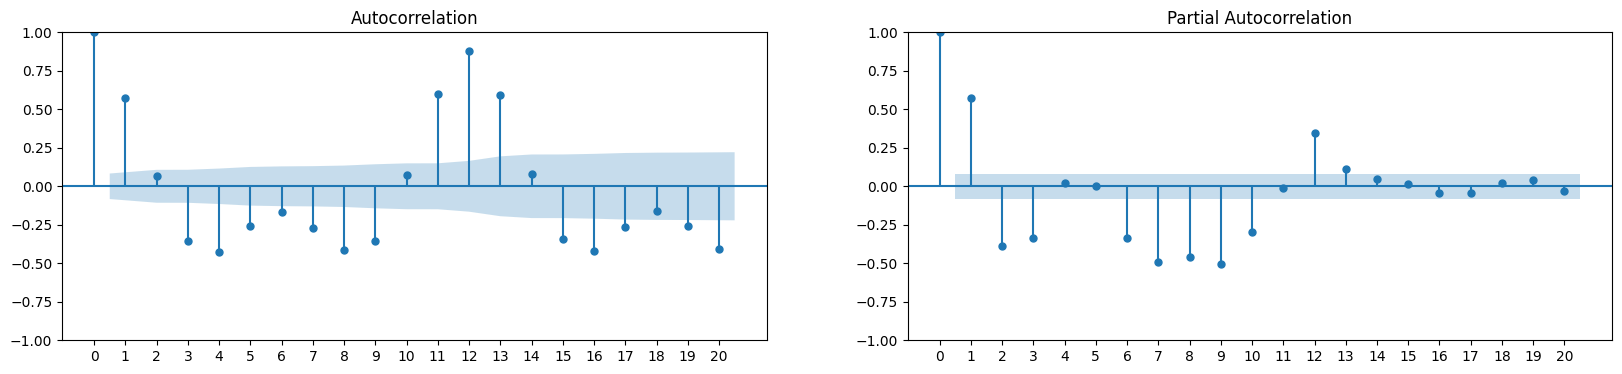

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

plot_acf(treino, lags=20, ax=axs[0])
plot_pacf(treino, lags=20, ax=axs[1])
axs[0].set_xticks(range(0, 21))
axs[1].set_xticks(range(0, 21))
plt.show()

In [20]:
ar_mod_f2 = AutoReg(treino, 10, old_names=False).fit()
print(ar_mod_f2.summary())

                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                  559
Model:                    AutoReg(10)   Log Likelihood                -993.284
Method:               Conditional MLE   S.D. of innovations              1.477
Date:                Thu, 29 Aug 2024   AIC                           2010.569
Time:                        14:53:05   BIC                           2062.266
Sample:                    12-01-1966   HQIC                          2030.773
                         - 08-01-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9748      3.244     34.518      0.000     105.617     118.333
temp.L1       -0.3349      0.037     -9.170      0.000      -0.406      -0.263
temp.L2       -0.3242      0.030    -10.926      0.0

## Understaing Residues

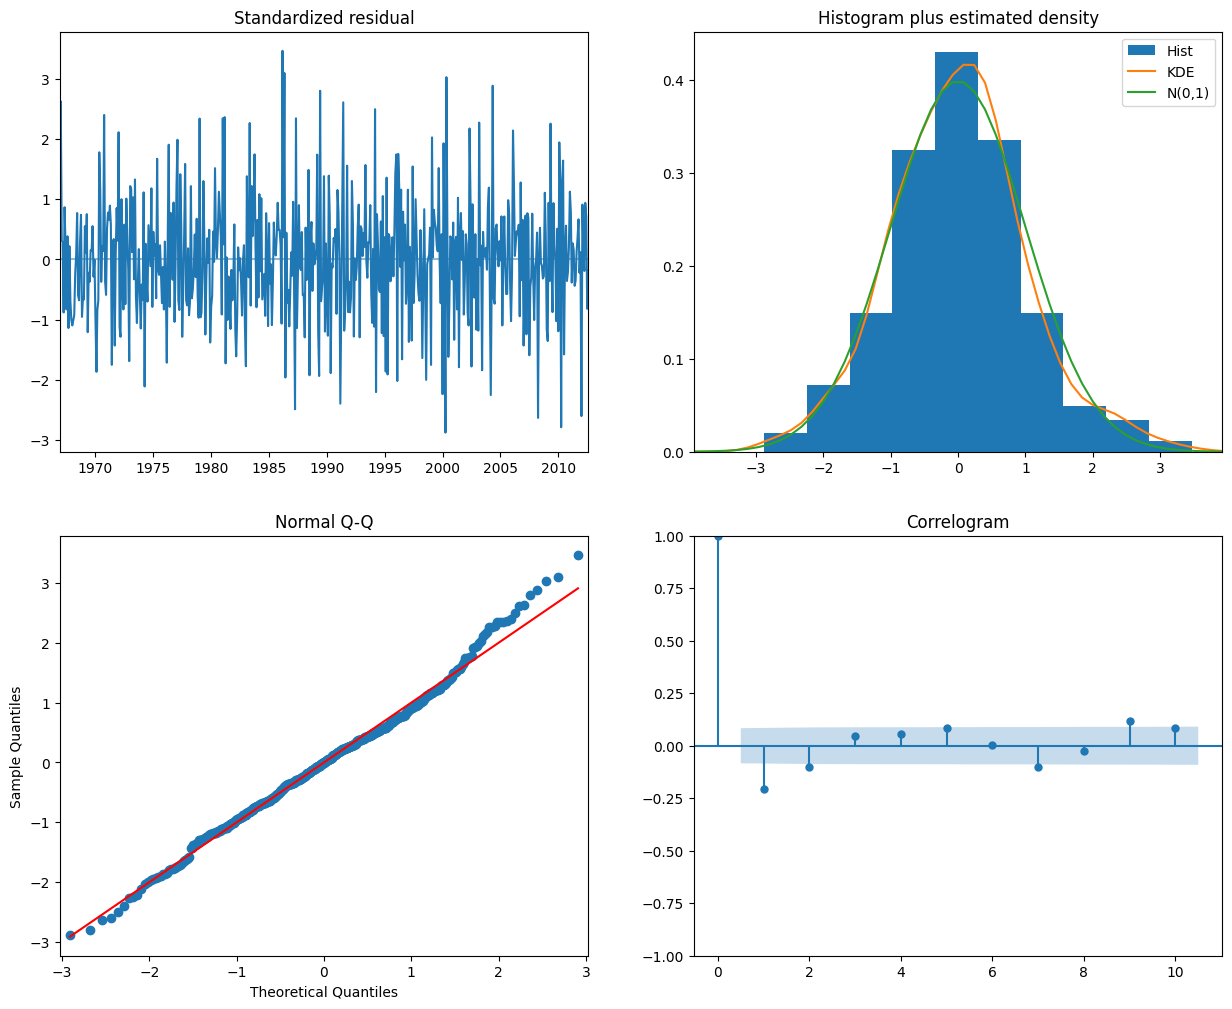

In [21]:
ar_mod_f2.plot_diagnostics(figsize=(15, 12))
plt.show()

## ARMA Model

We'll use the ARIMA model implemented in statsmodels with $d=0$

In [22]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(treino, order=(10, 0, 1)).fit()
#order=(p, d, q)

print(arma_mod.summary())

d:\Documents\Coding\Repositorios\MyRepositories\Alura\TimeSeries\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  559
Model:                ARIMA(10, 0, 1)   Log Likelihood                -988.512
Date:                Thu, 29 Aug 2024   AIC                           2003.023
Time:                        14:53:07   BIC                           2059.263
Sample:                    02-01-1966   HQIC                          2024.985
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9727      0.008   2364.877      0.000      19.956      19.989
ar.L1         -0.0891      0.058     -1.542      0.123      -0.202       0.024
ar.L2         -0.3211      0.034     -9.505      0.0

d:\Documents\Coding\Repositorios\MyRepositories\Alura\TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


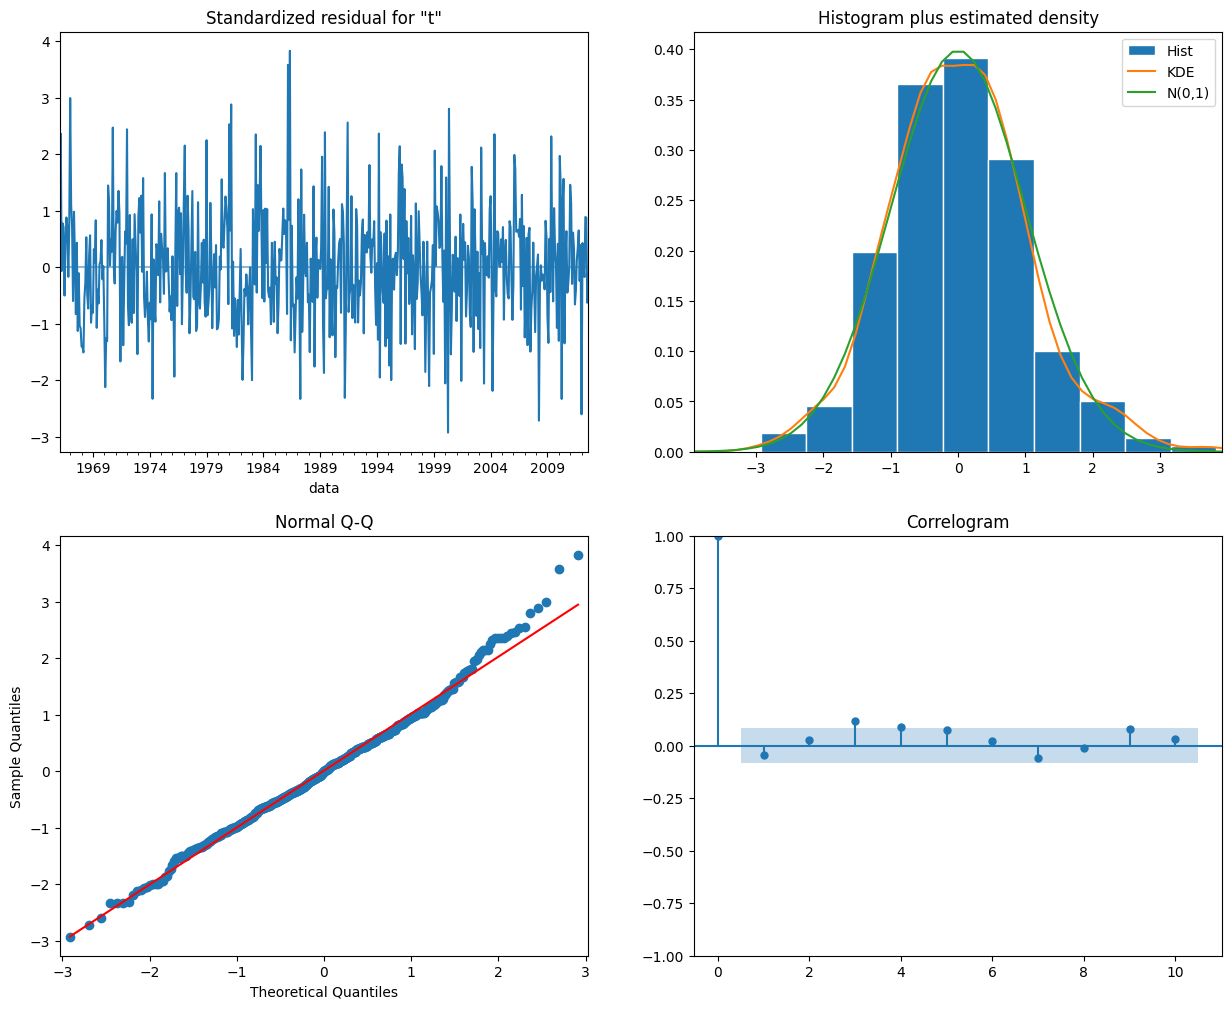

In [23]:
arma_mod.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
import itertools

# Bad because tends to favor overfitted models
def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
    p_params = range(p_inicial, p_final)
    q_params = range(q_inicial, q_final)
    d_params = [d_valores]

    combinacoes = list(itertools.product(p_params, d_params, q_params))

    aic_grid = dict()

    for order in combinacoes:
        try:
            model = ARIMA(treino, order=order).fit()
            aic_grid[order] = list()
            aic_grid[order].append((model.aic if model.aic else float("inf")))
        except:
            continue
    return aic_grid, min(aic_grid, keu=lambda x: aic_grid[x][0])

In [25]:
import warnings
warnings.filterwarnings("ignore")

# aic_arma = grid_arima(10, 25, 1, 3, 0, treino)

In [27]:
arma_mod_ot = ARIMA(treino, order=(24, 0, 2)).fit()
print(arma_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  559
Model:                ARIMA(24, 0, 2)   Log Likelihood                -934.111
Date:                Thu, 29 Aug 2024   AIC                           1924.222
Time:                        14:54:33   BIC                           2045.354
Sample:                    02-01-1966   HQIC                          1971.525
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9729      0.004   4630.378      0.000      19.964      19.981
ar.L1         -0.4115      0.318     -1.296      0.195      -1.034       0.211
ar.L2          0.1878      0.130      1.444      0.1

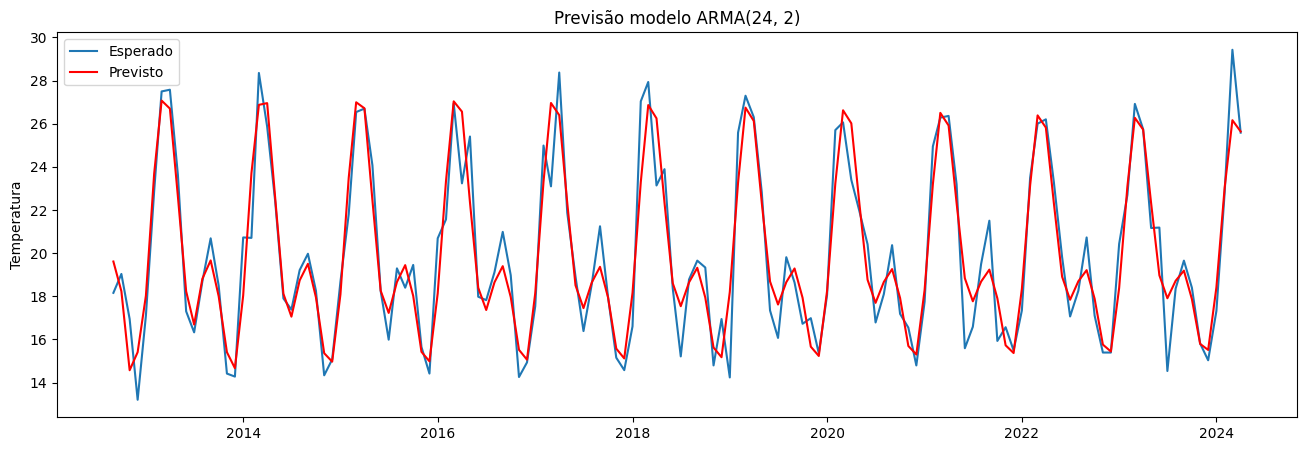

Métricas:
MAE: 1.0654745046911593
MSE 1.9803159888070863


In [28]:
plot_prev(treino, teste, arma_mod_ot, "ARMA(24, 2)")

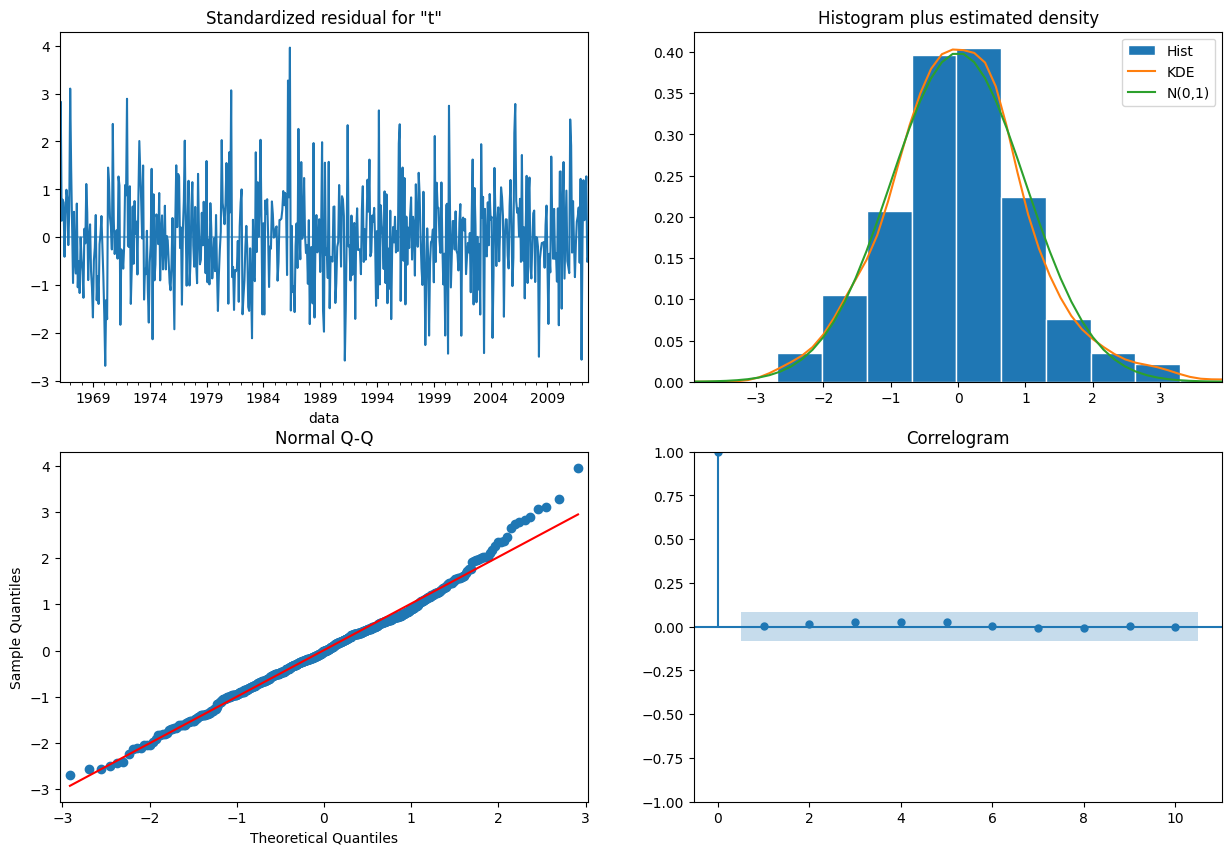

In [30]:
arma_mod_ot.plot_diagnostics(figsize=(15, 10))
plt.show()

# Third Data Set - Non Stationary

In [31]:
df_f3 = pd.read_csv(dados_f3)

df_f3.columns = [col.lower() for col in df_f3.columns]
df_f3["data"] = pd.to_datetime(df_f3["data"])
df_f3.set_index(["data"], inplace=True, drop=True)

<Axes: xlabel='data'>

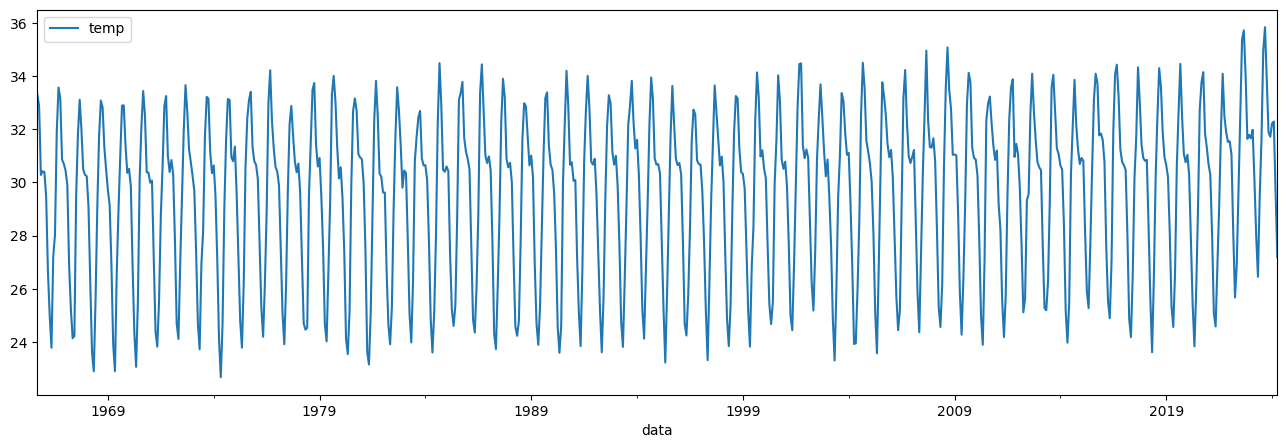

In [33]:
df_f3.plot(figsize=(16, 5))

In [37]:
estac(df_f3)

ADF p-value: 0.0669
Não rejeitar a hipótese nula: A série não é estacionária

KPSS p-value: 0.0100
Não rejeitar a hipótese nula: A série não é estacionária



## Differencing

In [38]:
df_f3.diff(1)

,temp
data,
1965-09-01,NaN
1965-10-01,-0.42
1965-11-01,-2.60
1965-12-01,0.14
1966-01-01,-0.03
...,...
2023-12-01,-0.16
2024-01-01,0.50
2024-02-01,0.07


In [39]:
estac(df_f3.diff(1).iloc[1:])

ADF p-value: 0.0000
Rejeitar a hipótese nula: A série é estacionária

KPSS p-value: 0.1000
Rejeitar a hipótese nula: A série é estacionária



In [40]:
divisao = int(len(df_f3)*0.8)

treino = df_f3.iloc[:divisao].asfreq("MS")
teste = df_f3.iloc[divisao:].asfreq("MS")

## Autocorrelation

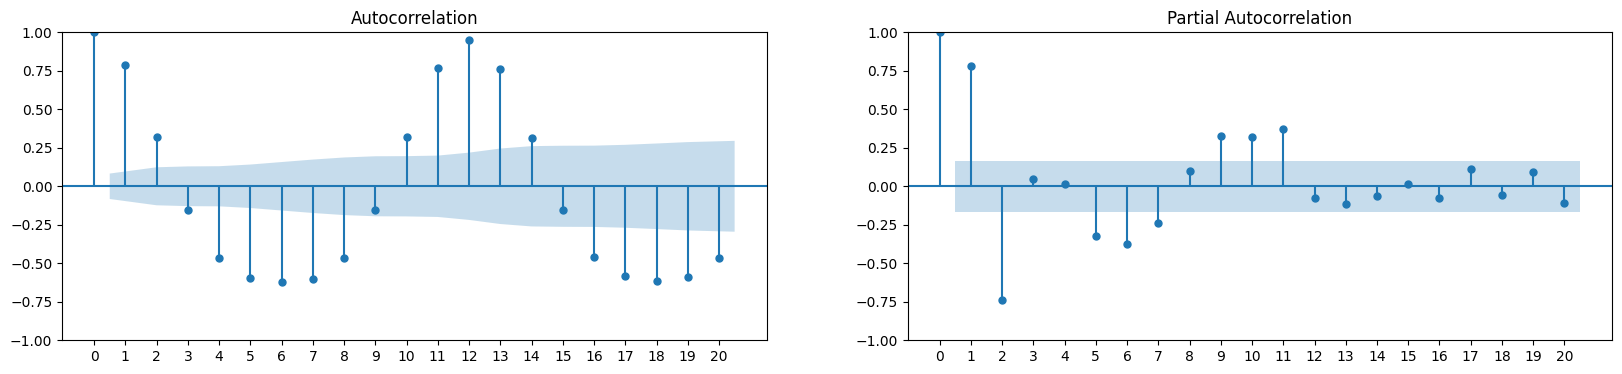

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

plot_acf(treino, lags=20, ax=axs[0])
plot_pacf(teste, lags=20, ax=axs[1])
axs[0].set_xticks(range(0, 21))
axs[1].set_xticks(range(0, 21))
plt.show()

## ARIMA Model

In [42]:
arima_mod = ARIMA(treino, order=(14, 1, 2)).fit()
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  563
Model:                ARIMA(14, 1, 2)   Log Likelihood                -544.630
Date:                Thu, 29 Aug 2024   AIC                           1123.260
Time:                        15:03:55   BIC                           1196.896
Sample:                    09-01-1965   HQIC                          1152.008
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4264      0.368     -1.158      0.247      -1.148       0.295
ar.L2          0.1403      0.399      0.351      0.725      -0.642       0.923
ar.L3         -0.2530      0.323     -0.784      0.4

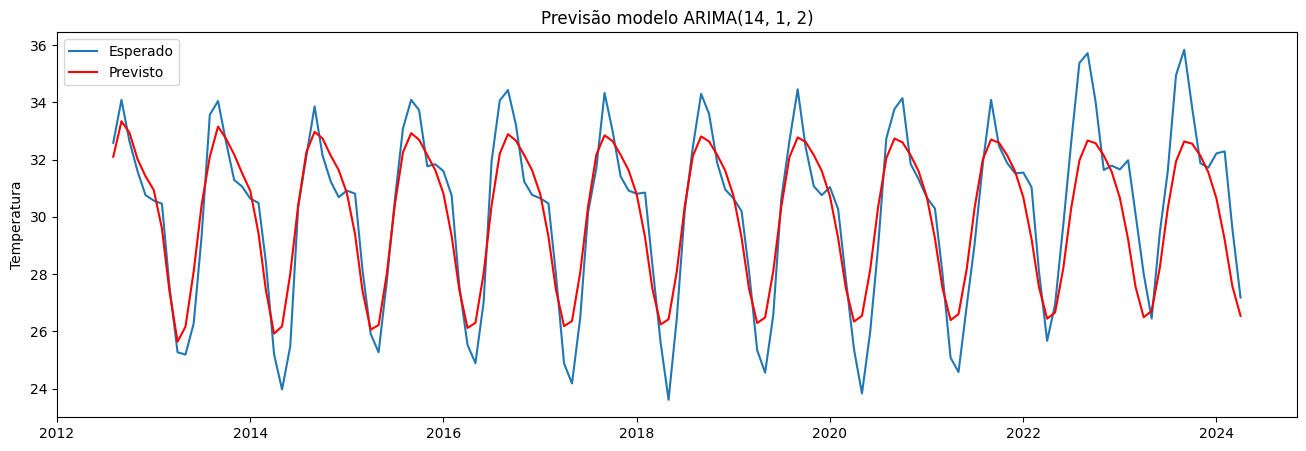

Métricas:
MAE: 1.0014459520136687
MSE 1.5905954674929361


In [43]:
plot_prev(treino, teste, arima_mod, "ARIMA(14, 1, 2)")

In [44]:
# aic_arima = grid_arima(14, 25, 1, 3, 1, treino)

In [47]:
arima_mod_ot = ARIMA(treino, order = (24, 1, 2)).fit()
print(arima_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  563
Model:                ARIMA(24, 1, 2)   Log Likelihood                -504.870
Date:                Thu, 29 Aug 2024   AIC                           1063.740
Time:                        15:06:17   BIC                           1180.690
Sample:                    09-01-1965   HQIC                          1109.399
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4530      0.153     -2.962      0.003      -0.753      -0.153
ar.L2          0.1533      0.084      1.830      0.067      -0.011       0.317
ar.L3         -0.1447      0.070     -2.077      0.0

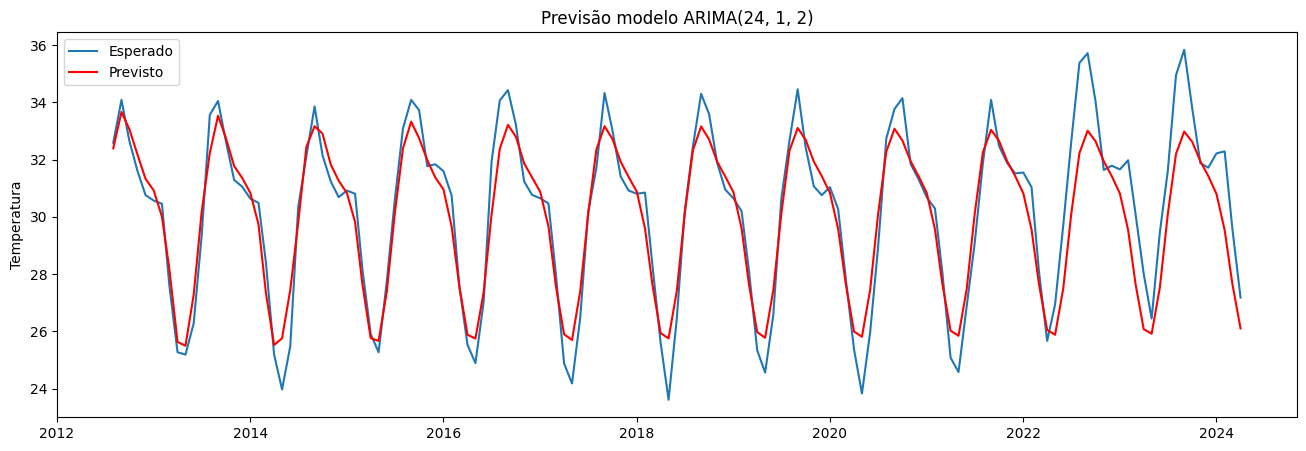

Métricas:
MAE: 0.8313878659661641
MSE 1.156124221928197


In [48]:
plot_prev(treino, teste, arima_mod_ot, "ARIMA(24, 1, 2)")

# Seasonality

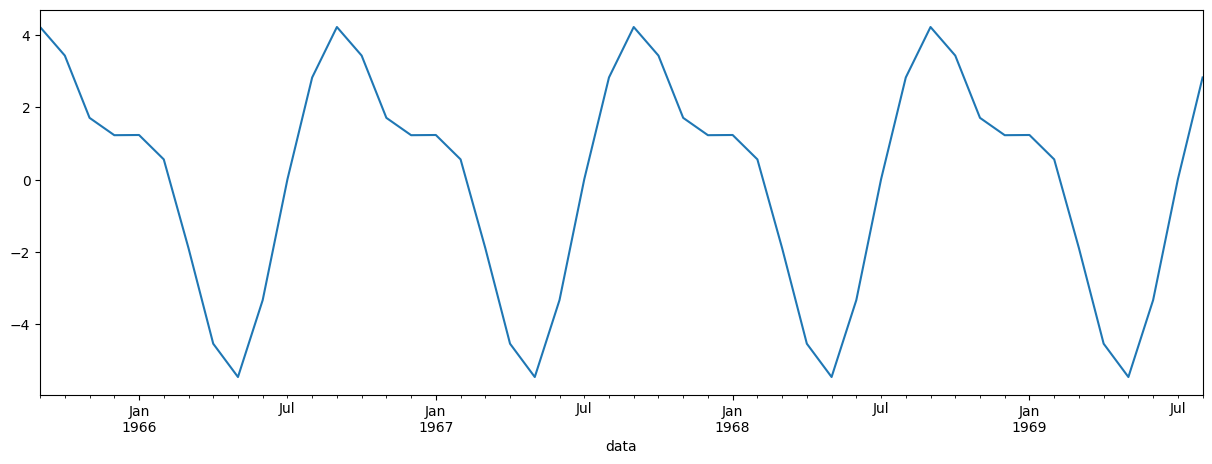

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_df = seasonal_decompose(df_f3)

fig = plt.figure(figsize=(15, 5))
decomposicao_df.seasonal[:48].plot()
plt.show()

Given the high seasonality in this data, ARIMA is not a good choice

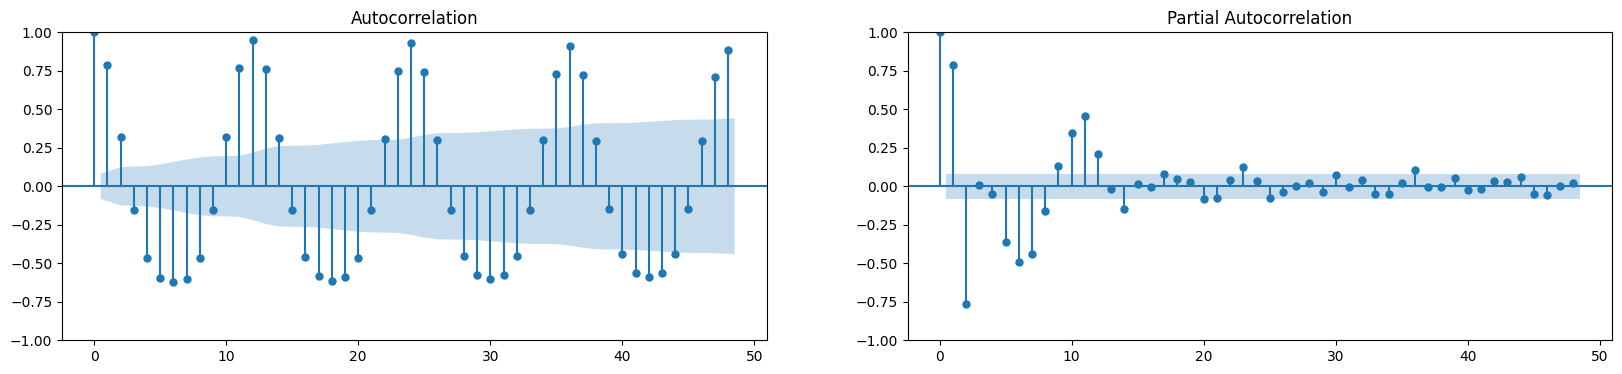

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

plot_acf(treino, lags=48, ax=axs[0])
plot_pacf(treino, lags=48, ax=axs[1])
plt.show()

# SARIMA

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_mod = SARIMAX(treino, order = (11, 1, 2), seasonal_order=(2,1,1,12)).fit()
print(sarima_mod.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  temp   No. Observations:                  563
Model:             SARIMAX(11, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -456.394
Date:                               Thu, 29 Aug 2024   AIC                            946.787
Time:                                       15:54:10   BIC                           1020.056
Sample:                                   09-01-1965   HQIC                           975.419
                                        - 07-01-2012                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5654      0.147     -3.837      0.000      -0.854      -0.277
ar.L2      

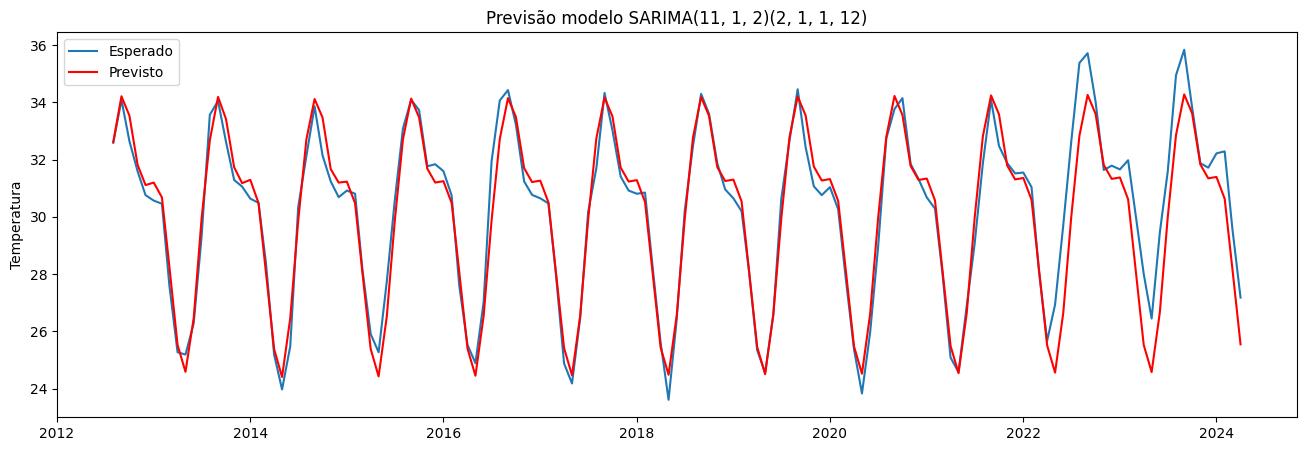

Métricas:
MAE: 0.5943402625333325
MSE 0.7494966121297246


In [62]:
plot_prev(treino, teste, sarima_mod, "SARIMA(11, 1, 2)(2, 1, 1, 12)")